Базова модель задачі задоволення обмежень:

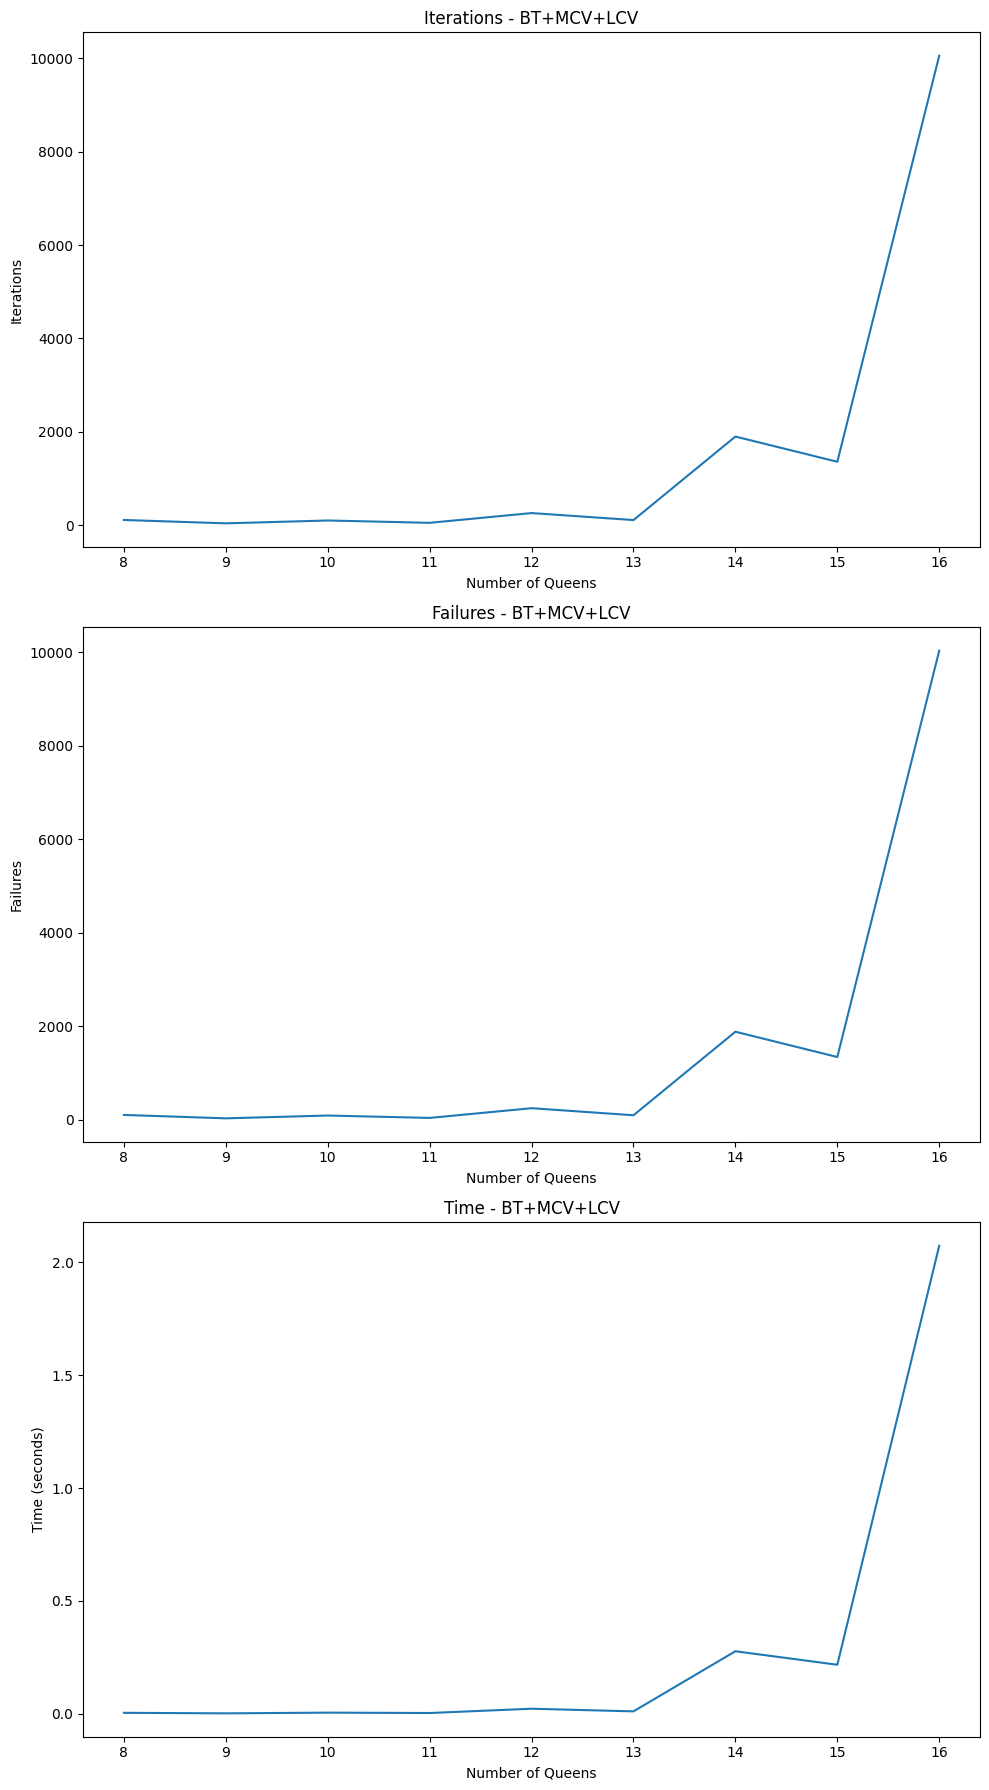

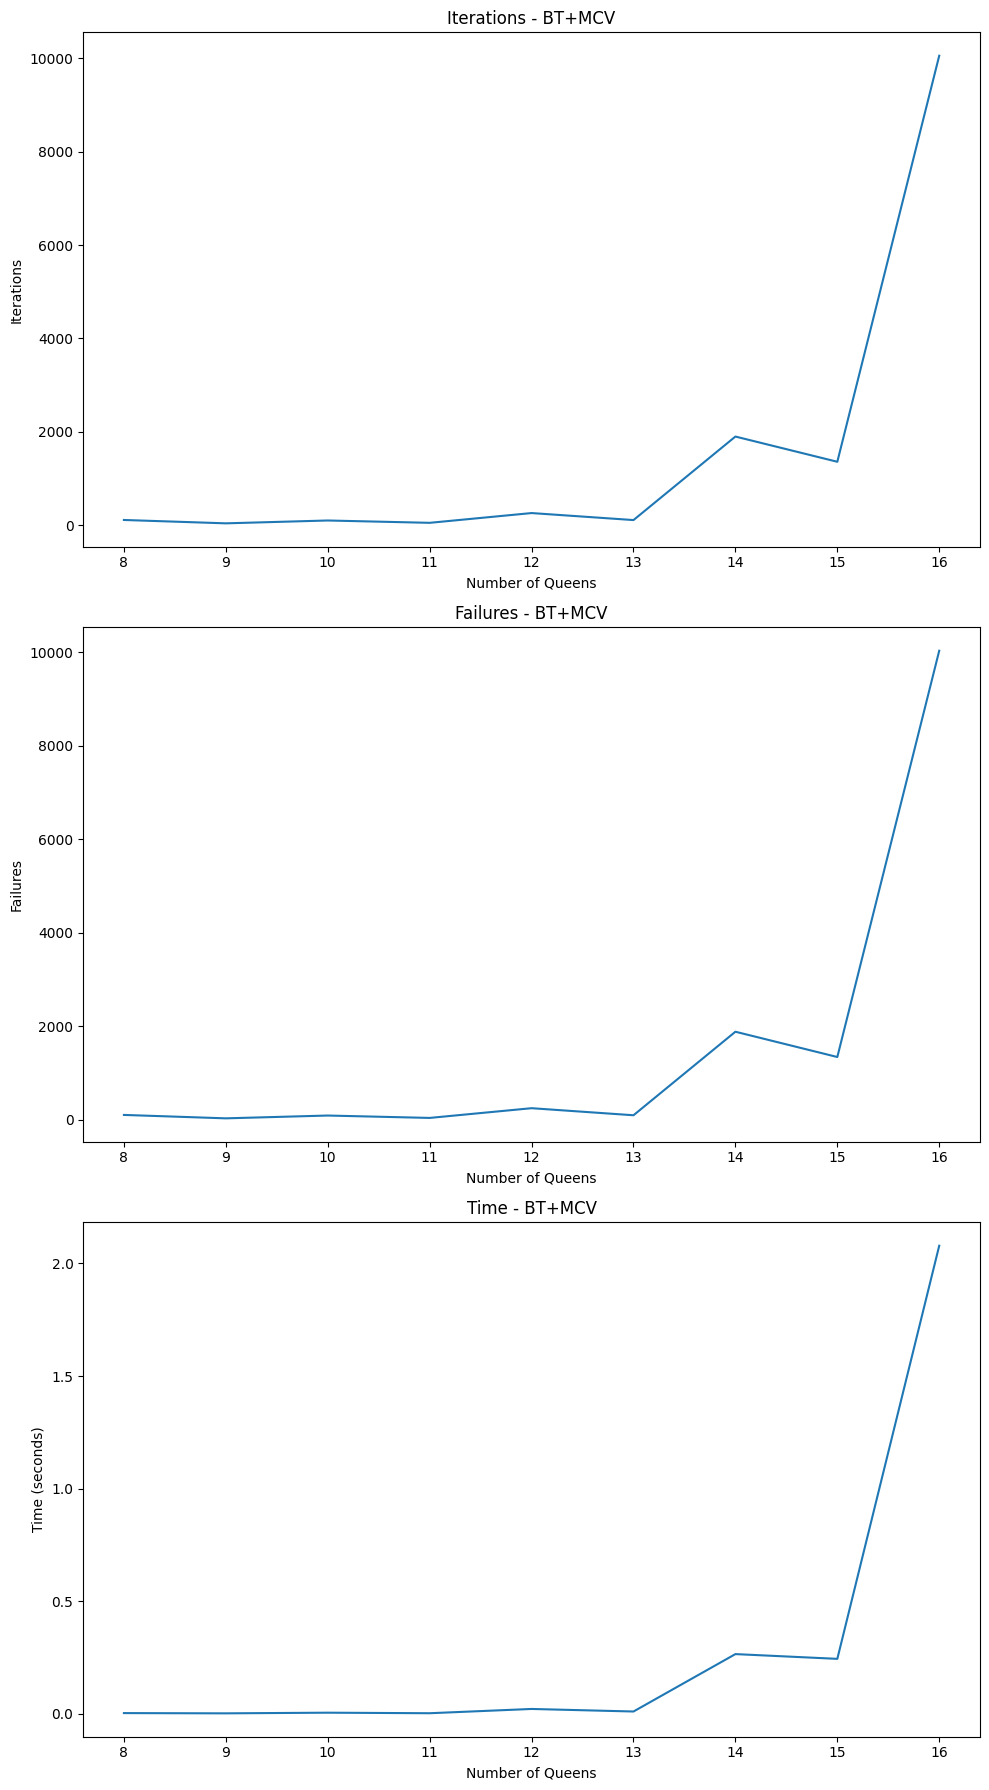

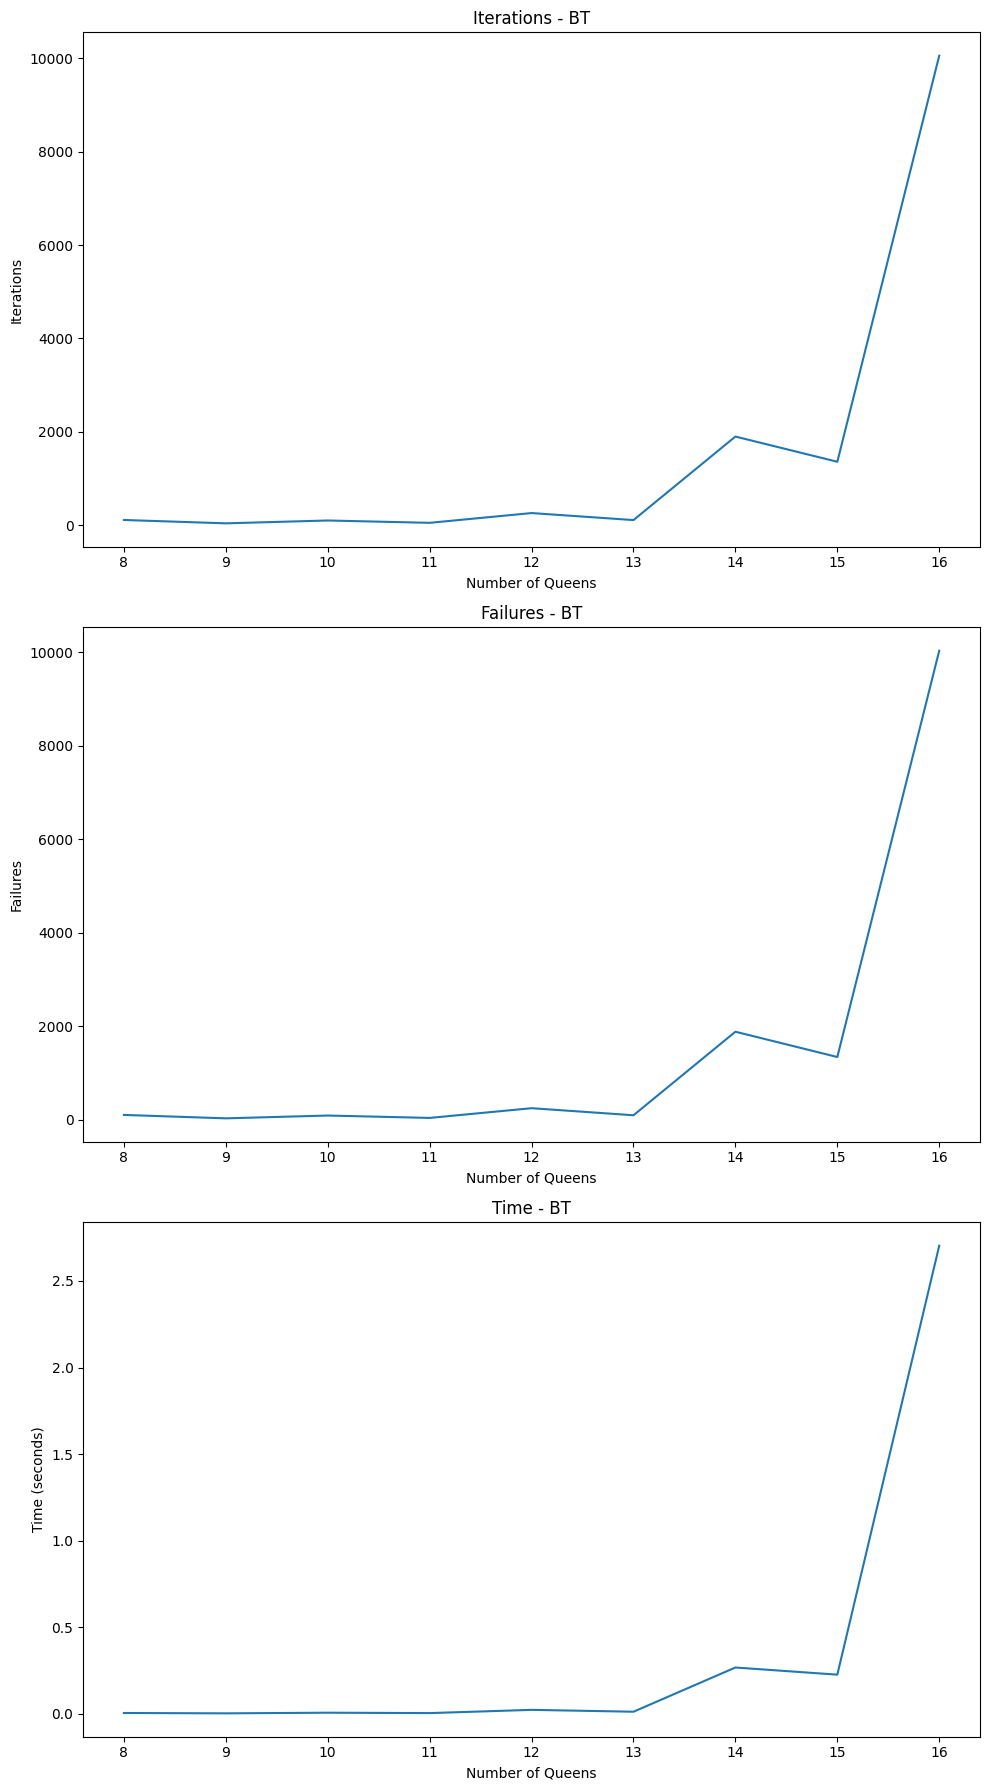

BT+MCV+LCV solution for 16 queens:
{1: 1, 2: 3, 3: 5, 4: 2, 5: 13, 6: 9, 7: 14, 8: 12, 9: 15, 10: 6, 11: 16, 12: 7, 13: 4, 14: 11, 15: 8, 16: 10}
BT+MCV solution for 16 queens:
{1: 1, 2: 3, 3: 5, 4: 2, 5: 13, 6: 9, 7: 14, 8: 12, 9: 15, 10: 6, 11: 16, 12: 7, 13: 4, 14: 11, 15: 8, 16: 10}
BT solution for 16 queens:
{1: 1, 2: 3, 3: 5, 4: 2, 5: 13, 6: 9, 7: 14, 8: 12, 9: 15, 10: 6, 11: 16, 12: 7, 13: 4, 14: 11, 15: 8, 16: 10}
BT+MCV+LCV Metrics:
Queens: 8, Iterations: 114, Failures: 105, Time: 0.004471540451049805
Queens: 9, Iterations: 42, Failures: 32, Time: 0.002161741256713867
Queens: 10, Iterations: 103, Failures: 92, Time: 0.005245685577392578
Queens: 11, Iterations: 53, Failures: 41, Time: 0.003602743148803711
Queens: 12, Iterations: 262, Failures: 249, Time: 0.022632598876953125
Queens: 13, Iterations: 112, Failures: 98, Time: 0.010918855667114258
Queens: 14, Iterations: 1900, Failures: 1885, Time: 0.27729177474975586
Queens: 15, Iterations: 1360, Failures: 1344, Time: 0.2174751758

In [25]:
import time
import matplotlib.pyplot as plt
from typing import Generic, TypeVar, Dict, List, Optional
from abc import ABC, abstractmethod
import copy

V = TypeVar('V')  # variable type
D = TypeVar('D')  # domain type


# Base class for all constraints
class Constraint(Generic[V, D], ABC):
    def __init__(self, variables: List[V]) -> None:
        self.variables = variables

    @abstractmethod
    def satisfied(self, assignment: Dict[V, D]) -> bool:
        pass


class CSP(Generic[V, D]):
    def __init__(self, variables: List[V], domains: Dict[V, List[D]]) -> None:
        self.variables: List[V] = variables
        self.domains: Dict[V, List[D]] = domains
        self.constraints: Dict[V, List[Constraint[V, D]]] = {}
        self.iterations = 0
        self.failures = 0
        for variable in self.variables:
            self.constraints[variable] = []
            if variable not in self.domains:
                raise LookupError("Every variable should have a domain assigned to it.")

    def add_constraint(self, constraint: Constraint[V, D]) -> None:
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError("Variable in constraint not in CSP", variable, self.variables)
            else:
                self.constraints[variable].append(constraint)

    def consistent(self, variable: V, assignment: Dict[V, D]) -> bool:
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True

    def backtracking_search(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
        self.iterations += 1  # Count each call to backtracking_search as an iteration

        if len(assignment) == len(self.variables):
            return assignment

        unassigned: List[V] = [v for v in self.variables if v not in assignment]
        first: V = unassigned[0]
        for value in self.domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            if self.consistent(first, local_assignment):
                result = self.backtracking_search(local_assignment)
                if result is not None:
                    return result
        self.failures += 1  # Count each time backtracking occurs
        return None


class CSP_BT_MCV_LCV(CSP[V, D]):
    def select_unassigned_variable(self, assignment: Dict[V, D]) -> V:
        unassigned: List[V] = [v for v in self.variables if v not in assignment]
        return min(unassigned, key=lambda var: len(self.domains[var]))

    def order_domain_values(self, variable: V, assignment: Dict[V, D]) -> List[D]:
        ordered_values = copy.deepcopy(self.domains[variable])
        ordered_values.sort(key=lambda val: self.conflicts(variable, val, assignment))
        return ordered_values

    def conflicts(self, variable: V, value: D, assignment: Dict[V, D]) -> int:
        count = 0
        for neighbor in self.neighbors[variable]:
            if neighbor in assignment:
                if assignment[neighbor] == value or abs(assignment[neighbor] - value) == abs(neighbor - variable):
                    count += 1
        return count


class CSP_BT_MCV(CSP[V, D]):
    def select_unassigned_variable(self, assignment: Dict[V, D]) -> V:
        unassigned: List[V] = [v for v in self.variables if v not in assignment]
        return min(unassigned, key=lambda var: len(self.domains[var]))

    def order_domain_values(self, variable: V, assignment: Dict[V, D]) -> List[D]:
        return self.domains[variable]


class QueensConstraint(Constraint[int, int]):
    def __init__(self, columns: List[int]) -> None:
        super().__init__(columns)
        self.columns: List[int] = columns

    def satisfied(self, assignment: Dict[int, int]) -> bool:
        # q1c = queen 1 column, q1r = queen 1 row
        for q1c, q1r in assignment.items():
            # q2c = queen 2 column
            for q2c in range(q1c + 1, len(self.columns) + 1):
                if q2c in assignment:
                    q2r: int = assignment[q2c]  # q2r = queen 2 row
                    if q1r == q2r:  # same row?
                        return False
                    if abs(q1r - q2r) == abs(q1c - q2c):  # same diagonal?
                        return False
        return True  # no conflict


class Metrics:
    def __init__(self):
        self.iterations = []
        self.failures = []
        self.time = []

    def add(self, iterations, failures, time):
        self.iterations.append(iterations)
        self.failures.append(failures)
        self.time.append(time)


def plot_metrics(metrics, method_name):
    fig, ax = plt.subplots(3, 1, figsize=(10, 18))

    # Iterations
    ax[0].plot(range(8, 17), metrics.iterations, label=f'{method_name}')
    ax[0].set_title(f'Iterations - {method_name}')
    ax[0].set_xlabel('Number of Queens')
    ax[0].set_ylabel('Iterations')

    # Failures
    ax[1].plot(range(8, 17), metrics.failures, label=f'{method_name}')
    ax[1].set_title(f'Failures - {method_name}')
    ax[1].set_xlabel('Number of Queens')
    ax[1].set_ylabel('Failures')

    # Time
    ax[2].plot(range(8, 17), metrics.time, label=f'{method_name}')
    ax[2].set_title(f'Time - {method_name}')
    ax[2].set_xlabel('Number of Queens')
    ax[2].set_ylabel('Time (seconds)')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    columns: List[int] = list(range(1, 9))
    rows: Dict[int, List[int]] = {column: list(range(1, 9)) for column in columns}

    metrics_bt_mcv_lcv = Metrics()
    metrics_bt_mcv = Metrics()
    metrics_bt = Metrics()

    solutions_bt_mcv_lcv = []
    solutions_bt_mcv = []
    solutions_bt = []

    for num_queens in range(8, 17):
        current_columns = list(range(1, num_queens + 1))
        current_rows: Dict[int, List[int]] = {column: list(range(1, num_queens + 1)) for column in current_columns}

        # Using CSP with BT+MCV+LCV
        csp: CSP_BT_MCV_LCV[int, int] = CSP_BT_MCV_LCV(current_columns, current_rows)
        csp.add_constraint(QueensConstraint(current_columns))

        start_time = time.time()
        solution: Optional[Dict[int, int]] = csp.backtracking_search()
        end_time = time.time()

        if solution is not None:
            metrics_bt_mcv_lcv.add(csp.iterations, csp.failures, end_time - start_time)
            solutions_bt_mcv_lcv.append(solution)

        # Using CSP with BT+MCV
        csp_bt_mcv: CSP_BT_MCV[int, int] = CSP_BT_MCV(current_columns, current_rows)
        csp_bt_mcv.add_constraint(QueensConstraint(current_columns))

        start_time = time.time()
        solution_bt_mcv: Optional[Dict[int, int]] = csp_bt_mcv.backtracking_search()
        end_time = time.time()

        if solution_bt_mcv is not None:
            metrics_bt_mcv.add(csp_bt_mcv.iterations, csp_bt_mcv.failures, end_time - start_time)
            solutions_bt_mcv.append(solution_bt_mcv)
        # Using CSP with BT
        csp_bt: CSP[int, int] = CSP(current_columns, current_rows)
        csp_bt.add_constraint(QueensConstraint(current_columns))

        start_time = time.time()
        solution_bt: Optional[Dict[int, int]] = csp_bt.backtracking_search()
        end_time = time.time()

        if solution_bt is not None:
            metrics_bt.add(csp_bt.iterations, csp_bt.failures, end_time - start_time)
            solutions_bt.append(solution_bt)


    plot_metrics(metrics_bt_mcv_lcv, "BT+MCV+LCV")
    plot_metrics(metrics_bt_mcv, "BT+MCV")
    plot_metrics(metrics_bt, "BT")
    # Print the solution for the last iteration (16 queens)
    if solutions_bt_mcv_lcv:
        print(f"BT+MCV+LCV solution for {num_queens } queens:")
        print(solutions_bt_mcv_lcv[-1])

    if solutions_bt_mcv:
        print(f"BT+MCV solution for {num_queens} queens:")
        print(solutions_bt_mcv[-1])
    if solutions_bt:
        print(f"BT solution for {num_queens} queens:")
        print(solutions_bt[-1])
    print("BT+MCV+LCV Metrics:")
    for i in range(len(metrics_bt_mcv_lcv.iterations)):
        print(f"Queens: {i+8}, Iterations: {metrics_bt_mcv_lcv.iterations[i]}, Failures: {metrics_bt_mcv_lcv.failures[i]}, Time: {metrics_bt_mcv_lcv.time[i]}")

    print("\nBT+MCV Metrics:")
    for i in range(len(metrics_bt_mcv.iterations)):
        print(f"Queens: {i+8}, Iterations: {metrics_bt_mcv.iterations[i]}, Failures: {metrics_bt_mcv.failures[i]}, Time: {metrics_bt_mcv.time[i]}")

    print("\nBT Metrics:")
    for i in range(len(metrics_bt.iterations)):
        print(f"Queens: {i+8}, Iterations: {metrics_bt.iterations[i]}, Failures: {metrics_bt.failures[i]}, Time: {metrics_bt.time[i]}")

